Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
from pyvi.ViTokenizer import ViTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Load data

In [2]:
TRAIN_DATA = '../data/ViHSD/train.csv'
DEV_DATA = '../data//ViHSD/dev.csv'
TEST_DATA = '../data/ViHSD/test.csv'

# read data
train_data = pd.read_csv(TRAIN_DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

train_data = train_data.dropna(subset=['free_text'])
dev_data = dev_data.dropna(subset=['free_text'])
test_data = test_data.dropna(subset=['free_text'])


print(len(train_data))
print(len(dev_data))
print(len(test_data))

24046
2672
6680


Data preprocessing

In [3]:
STOPWORDS = '../data/vietnamese-stopwords-dash.txt'
stopwords = []

with open(STOPWORDS, "r") as ins:
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    # remove emoji
    emoji_pattern = re.compile(
        pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002702-\U000027B0"  # Dingbats
            u"\U000024C2-\U0001F251"  # Enclosed characters
            u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
            u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
            u"\U0000200D"              # Zero Width Joiner
            u"\U0000200C"              # Zero Width Non-Joiner
            "]+", 
        flags = re.UNICODE
    )

    text = emoji_pattern.sub(r'', text)  
    return text

def deSpecialCharacters(text):
    text =  re.sub('\W+',' ', text )
    return text

def preprocess(text, tokenized = True, lowercased = True):
    text = deEmojify(text)
    text = deSpecialCharacters(text)
    text = re.sub(r'\s+', ' ', text).strip() 
    text = text.lower() if lowercased else text
    # text = replace_teencode(text)
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)# text = filter_stop_words(text, stopwords)
    return text

In [4]:
train_data['free_text'] = train_data['free_text'].apply(preprocess)
test_data['free_text'] = train_data['free_text'].apply(preprocess)
dev_data['free_text'] = train_data['free_text'].apply(preprocess)
train_data = train_data[train_data['free_text'] != '']
test_data = test_data[test_data['free_text'] != '']
dev_data = dev_data[dev_data['free_text'] != '']

In [5]:
tr_text = train_data['free_text']
tr_label = train_data['label_id']

val_text = dev_data['free_text']
val_label = dev_data['label_id']

ts_text = test_data['free_text']
ts_label = test_data['label_id']

Feature

In [6]:
vocabulary_size = 10000
sequence_length = 100

tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(tr_text) 
                            
sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=sequence_length) 
tr_y = to_categorical(tr_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=sequence_length)
val_y = to_categorical(val_label, num_classes=2)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=sequence_length)
ts_y = to_categorical(ts_label, num_classes=2)

note

Run model

In [7]:
max_words = 10000
max_len = 100
embedding_dim = 32

In [8]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.3))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.3))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.2)(hid_layer)
output_layer = Dense(2, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [9]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 100)]                0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 100)]                0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 100, 32)              320000    ['embedding_input[0][0]']     
                                                                                              

In [10]:
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True,min_delta=0.001)
class_weights = {0: 1.0, 1: 3.0}

batch_size = 256
epochs = 25 # 40, 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y),
                    # callbacks=[early_stopping],
                    class_weight=class_weights
                    )

Epoch 1/25
93/93 [==============================] - 11s 105ms/step - loss: 0.8535 - accuracy: 0.7398 - precision: 0.7398 - recall: 0.7398 - val_loss: 0.6595 - val_accuracy: 0.8138 - val_precision: 0.8138 - val_recall: 0.8138
Epoch 2/25
93/93 [==============================] - 9s 98ms/step - loss: 0.6470 - accuracy: 0.8298 - precision: 0.8298 - recall: 0.8298 - val_loss: 0.6504 - val_accuracy: 0.7483 - val_precision: 0.7483 - val_recall: 0.7483
Epoch 3/25
93/93 [==============================] - 9s 97ms/step - loss: 0.5246 - accuracy: 0.8609 - precision: 0.8609 - recall: 0.8609 - val_loss: 0.6317 - val_accuracy: 0.7184 - val_precision: 0.7184 - val_recall: 0.7184
Epoch 4/25
93/93 [==============================] - 9s 99ms/step - loss: 0.4422 - accuracy: 0.8886 - precision: 0.8886 - recall: 0.8886 - val_loss: 0.6330 - val_accuracy: 0.6820 - val_precision: 0.6820 - val_recall: 0.6820
Epoch 5/25
93/93 [==============================] - 9s 102ms/step - loss: 0.3883 - accuracy: 0.8985 - prec

Save model

In [13]:
import pickle
with open('../models/tokenizer_cnn_hsd.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

model.save('../models/model_cnn_hsd.h5')

c:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluation and Visullize results

In [11]:
def evaluation(y_pred, y_test):
    # Tính toán các chỉ số đánh giá
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-micro: {f1_micro}")
    print(f"F1-macro: {f1_macro}")

[[4409 1023]
 [ 885  225]]
Accuracy: 0.7083460715377561
Precision: 0.5065590399872134
Recall: 0.5071871392747681
F1-micro: 0.7083460715377561
F1-macro: 0.5064770914080504
None


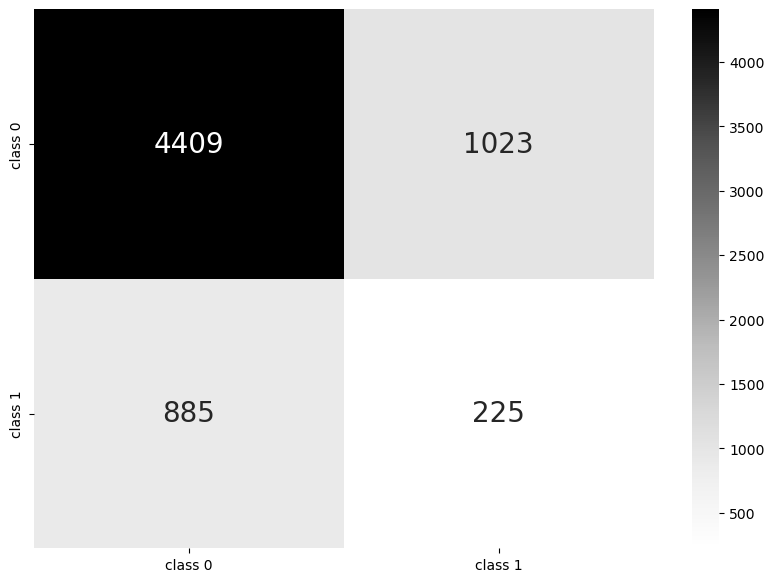

In [12]:
predictions = model.predict([ts_x, ts_x], batch_size=batch_size, verbose=0)
y_pred = predictions.argmax(axis=-1)
y_true = ts_label

# Tính toán confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

print(evaluation(y_pred, y_true))

# Vẽ confusion matrix
df_cm = pd.DataFrame(cf_matrix, index=["class 0", "class 1"],
                     columns=["class 0", "class 1"])
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap="Greys", fmt='g', cbar=True, annot_kws={"size": 20})
plt.show()